Mostrando os parâmetros das MLP's que foram definidos em params.json. O batch size utilizado para simular o GD foi de 3750 (5000 - tamanho do set de treino)

In [5]:
{
    "metric": "accuracy",
    "test_set_percentage": 0.25,
    "epochs": 200,

    "batch_sizes": [50, 10, 1],
    "hidden_layer_neuron_numbers": [25, 50, 100],
    "learning_rates":[10, 1, 0.5]
}

{'metric': 'accuracy',
 'test_set_percentage': 0.25,
 'epochs': 200,
 'batch_sizes': [50, 10, 1],
 'hidden_layer_neuron_numbers': [25, 50, 100],
 'learning_rates': [10, 1, 0.5]}

Importando todas as bibliotecas necessárias

In [6]:
import pickle
from sklearn.model_selection import train_test_split
from keras.models import load_model
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import json
from keras.callbacks import History

2023-05-22 15:49:51.250117: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-22 15:49:51.291519: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-22 15:49:51.292112: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-22 15:49:52.360212: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Treinando os 36 modelos e salvando em disco

In [ ]:
def trainMLP(metric, epochs, hidden_layer_neuron_number, learning_rate, batch_size, test_set_percentage):
    # definindo o modelo
    mlp = tf.keras.models.Sequential()
    mlp.add(layers.Dense(784, activation='sigmoid', input_shape=(784,)))
    mlp.add(layers.Dense(hidden_layer_neuron_number, activation='sigmoid'))
    mlp.add(layers.Dense(10, activation='sigmoid'))

    # compilando o modelo
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    mlp.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=[metric])

    # lendo os dados do arquivo de texto
    data = np.loadtxt('data_tp1', delimiter=',')
    X = data[:, 1:]
    y = data[:, 0]

    history = History()
    mlp.fit(X, y, validation_split=test_set_percentage, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True, workers=8, callbacks=[history])
    return (mlp, history)

def saveMLP(base_folder, mlp, learning_rate, history):
    if not os.path.exists('models'):
        os.makedirs('models')

    with open(f"{base_folder}/history-lr{learning_rate}.pkl", 'wb') as file:
        pickle.dump(history.history, file)
        
    mlp.save(f"{base_folder}/mlp-lr{learning_rate}")

params = json.load(open('params.json'))

test_set_percentage = params['test_set_percentage']
metric = params['metric']
epochs = params['epochs']

# Ordenado de forma que as primeiras execuções sejam mais rápidas
batch_sizes = [round(5000 * round(1 - params['test_set_percentage'], 2))]
for batch_size in params.get('batch_sizes'):
    batch_sizes.append(batch_size)
# batch_sizes = [3750, 50, 10, 1] Originalmente

hidden_layer_neuron_numbers = params['hidden_layer_neuron_numbers']
learning_rates = params['learning_rates']

for batch_size in batch_sizes:
    batch_folder = f"models/batch-size-{batch_size}"
    if not os.path.exists(batch_folder):
        os.makedirs(batch_folder)

    for hidden_layer_neuron_number in hidden_layer_neuron_numbers:
        hidden_layer_folder = f"{batch_folder}/hidden-layer-neuron-number-{hidden_layer_neuron_number}"
        if not os.path.exists(hidden_layer_folder):
            os.makedirs(hidden_layer_folder)

        for learning_rate in learning_rates:
            mlp, history = trainMLP(metric, epochs, hidden_layer_neuron_number, learning_rate, batch_size, test_set_percentage)
            saveMLP(hidden_layer_folder, mlp, learning_rate, history)

Carregando os modelos treinados para a memória

In [18]:
params = json.load(open('params.json'))

test_set_percentage = params['test_set_percentage']
metric = params['metric']
epochs = params['epochs']

# Ordenado de forma que as primeiras execuções sejam mais rápidas
batch_sizes = [round(5000 * round(1 - params['test_set_percentage'], 2))]
for batch_size in params.get('batch_sizes'):
    batch_sizes.append(batch_size)

hidden_layer_neuron_numbers = params['hidden_layer_neuron_numbers']
learning_rates = params['learning_rates']

models = {}
for batch_size in batch_sizes:
    batch_folder = f"models/batch-size-{batch_size}"
    if not os.path.exists(batch_folder):
        os.makedirs(batch_folder)

    for hidden_layer_neuron_number in hidden_layer_neuron_numbers:
        hidden_layer_folder = f"{batch_folder}/hidden-layer-neuron-number-{hidden_layer_neuron_number}"
        
        for learning_rate in learning_rates:
            mlp = load_model(f"{hidden_layer_folder}/mlp-lr{learning_rate}")
            history = pickle.load(open(f"{hidden_layer_folder}/history-lr{learning_rate}.pkl", 'rb'))

            if models.get(hidden_layer_neuron_number) is None:
                models[hidden_layer_neuron_number] = {}

            if models[hidden_layer_neuron_number].get(batch_size) is None:
                models[hidden_layer_neuron_number][batch_size] = {}
            
            models[hidden_layer_neuron_number][batch_size][learning_rate] = (mlp, history)

Plotando os gŕaficos de Erro empírico e erro de teste em função do número de épocas para cada combinação de (número de neurônios na camada oculta, tamanho do batch). Agrupei todos os learning rates de cada combinação em uma só figura para facilitar a visualização dos resultados.

Primeiramente analisarei os modelos com learning rate de 10, já que seu comportamento é bem diferente dos modelos com outros learning rates.

Os modelos com máximo learning rate sempre geram erros empíricos maiores em relação aos outros. O tamanho do batch não altera em muito a estabilidade do erro empírico, já que o modelo está (no geral) variando em um intervalo de erro que não muda de tamanho (para um determinado número de neuronios na camada oculta). Isso deve ser por conta dele estar dando "overshooting" no mínimo local encontrado em função da taxa de aprendizado alta. Dessa forma o algoritmo sempre anda por uma região proxima do mínimo e possui dificuldade de se guiar ao mínimo de fato. 

Mas o tamanho do batch de fato altera para qual número o erro empírico está "convergindo", com batches menores o erro converge para números maiores. Quando vamos diminuindo o batch size o caminho da descida de gradiente se torna cada vez mais caótico (como é bem explicito no SGD), e como o learning rate é muito alto pode ser que uma maior taxa de atualização nos pesos (menor batch size) acabe fazendo com que o algorítmo de descida de gradiente desvie para uma região totalmente diferente da região desejada. Uma das vantagens de ter um batch size grande é que o algoritmo de descida se torna menos suscetível as variações individuais dos dados, com um batch pequeno uma variação grande de um único dado afeta muito a direção resultante da descida.

Por conta desses fatores não conseguimos tirar conclusões confiáveis a respeito do número ideal de neuronios na camada oculta

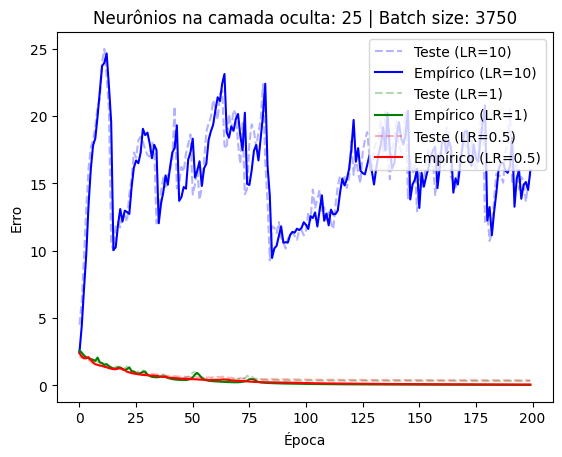

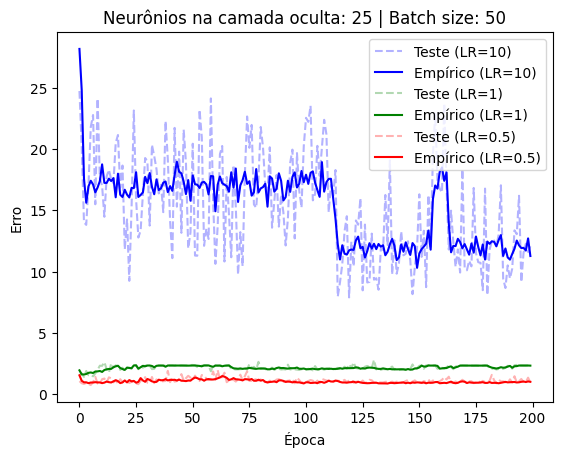

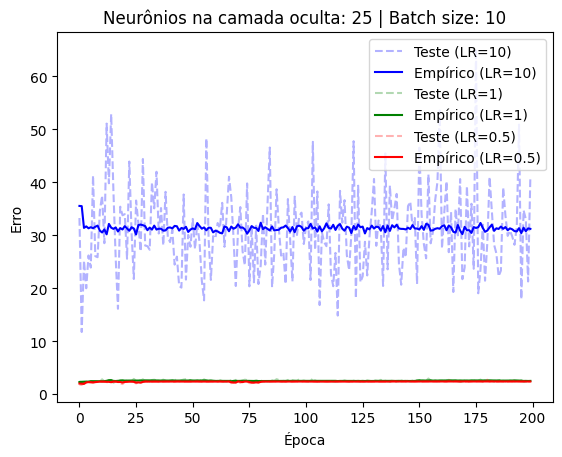

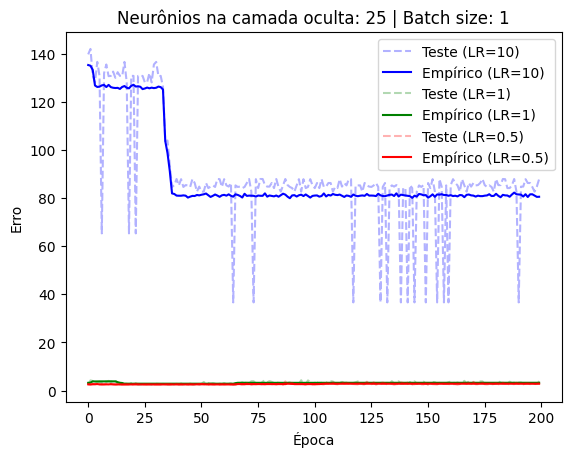

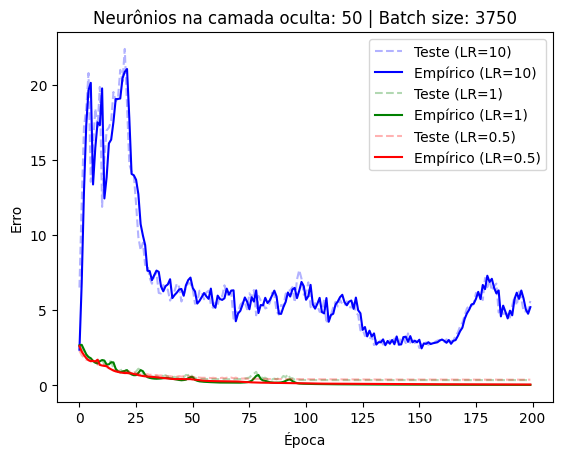

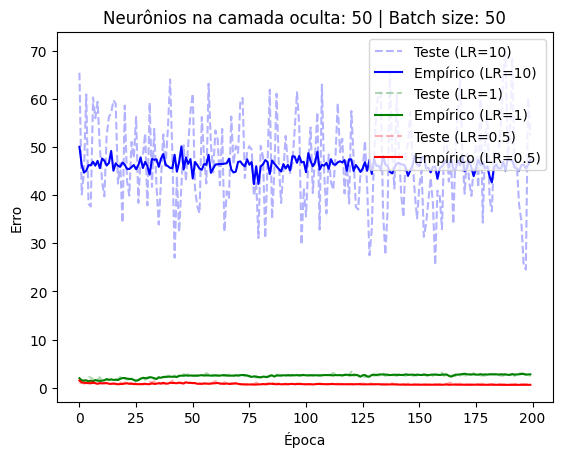

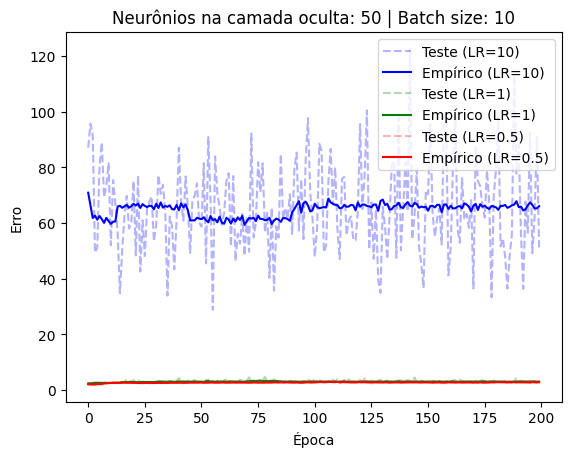

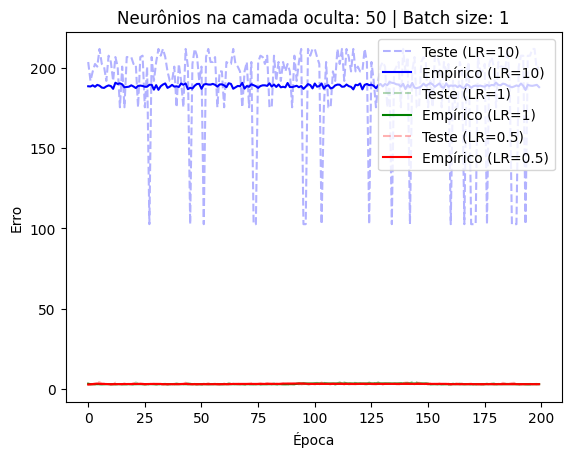

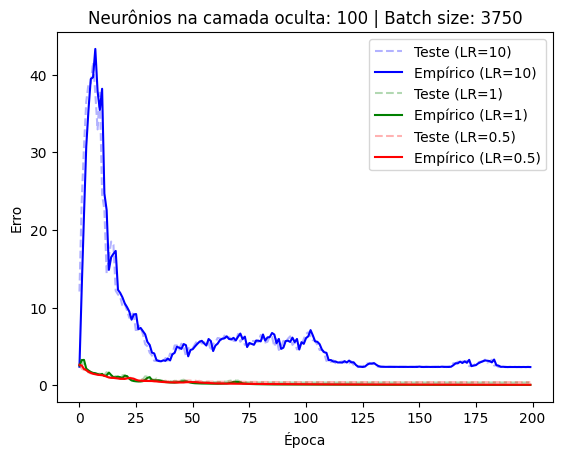

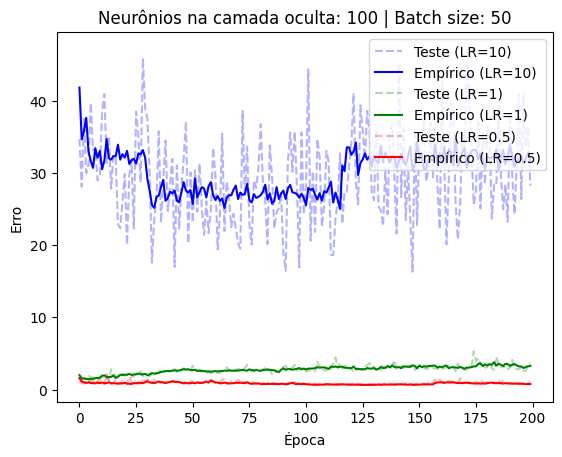

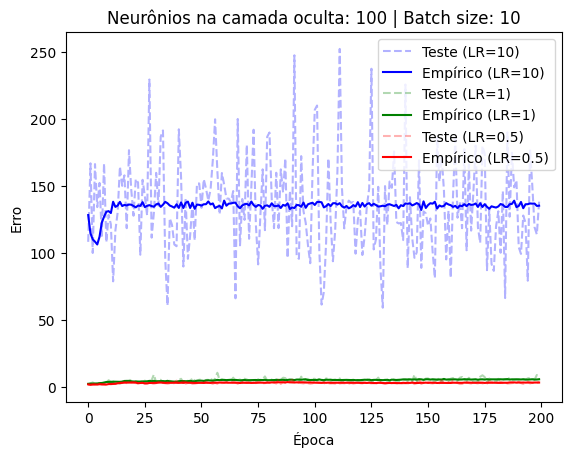

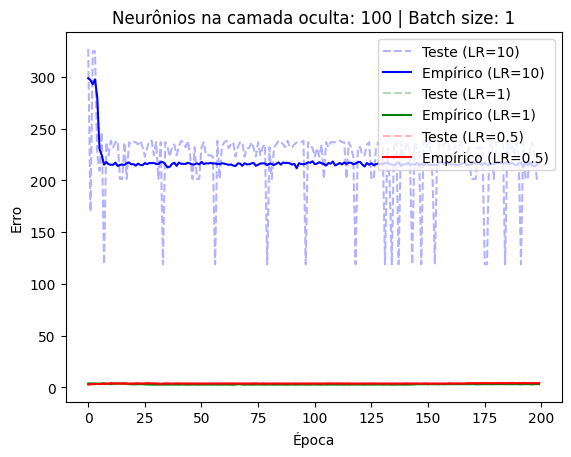

<Figure size 640x480 with 0 Axes>

In [19]:
for hidden_layer_neuron_number, model_group in models.items():
    for batch_size, model_group in model_group.items():
        colors = ['blue', 'green', 'red']
        labels = []
        color_index = -1

        for learning_rate, model in model_group.items():
            color_index += 1
            color = colors[color_index]
            mlp, history = model

            plt.plot(history['val_loss'], color=color, linestyle='dashed', alpha=0.3)
            plt.plot(history['loss'], color=color, linestyle='solid')
            
            labels.append(f"Teste (LR={learning_rate})")
            labels.append(f"Empírico (LR={learning_rate})")

        plt.title(f"Neurônios na camada oculta: {hidden_layer_neuron_number} | Batch size: {batch_size}")
        plt.ylabel('Erro')
        plt.xlabel('Época')
        plt.legend(labels, loc='upper right')
        plt.show()
        plt.clf()